# WDSR

In [1]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.wdsr import wdsr_b
from train import WdsrTrainer
import tensorflow as tf
%matplotlib inline

In [2]:
# Number of residual blocks
depth = 26

# Super-resolution factor
scale = 1

# Downgrade operator
downgrade = 'bicubic'

In [3]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [4]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [5]:
train_ds = div2k_train.dataset(batch_size=1, random_transform=False)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://drive.google.com/open?id=1JfQNGQZ9cG-lyC5EB0W3MpySjPlDJXpU) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [6]:
model=wdsr_b(scale=scale, num_res_blocks=depth)

In [7]:
model.summary(110)

Model: "wdsr"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                [(None, None, None, 2)] 0                                                 
______________________________________________________________________________________________________________
conv2d (Conv2D)                     (None, None, None, 32)  608          input_1[0][0]                        
______________________________________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, None, None, 192) 6336         conv2d[0][0]                         
______________________________________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, None, None, 25)  4825         conv2d_1[0][0]           

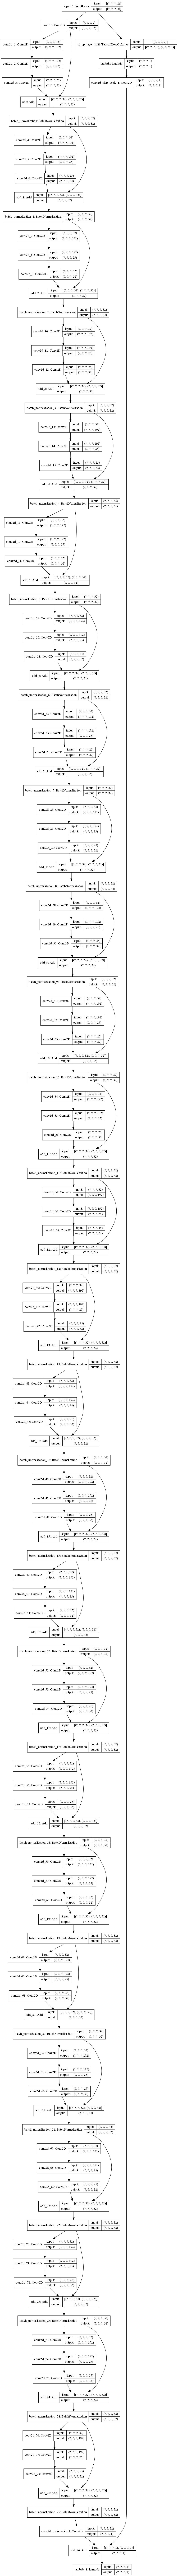

In [8]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [9]:
trainer = WdsrTrainer(model=wdsr_b(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/wdsr-{depth}-x{scale}')

In [23]:
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(1),
              steps=4000, 
              evaluate_every=100, 
              save_best_only=True)

3600/4000: loss = 0.588, PSNR = -82.898773 (26.72s)
3700/4000: loss = 0.582, PSNR = -82.924393 (26.65s)
3800/4000: loss = 0.577, PSNR = -82.921883 (26.82s)
3900/4000: loss = 0.573, PSNR = -82.900864 (26.79s)
4000/4000: loss = 0.568, PSNR = -82.908791 (26.87s)


In [24]:
# Restore from checkpoint with highest PSNR
#trainer.restore()

In [ ]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

In [13]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [14]:
from model import resolve_single
from utils import load_image, plot_sample
import cv2

model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [15]:
def plot_diff(lr, sr):
    plt.figure(figsize=(30, 10))
    diff = cv2.subtract(np.array(lr,np.float32),np.array(sr,np.float32))
    #diff_lr_hr = np.clip(diff,0,1000)
    images = [lr, sr, diff]
    titles = ['LR','HR','Difference']
      
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        heatmap = plt.pcolor(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(heatmap)


In [16]:
from math import log10, sqrt 
import cv2 
import numpy as np 
from skimage.metrics import structural_similarity 
import argparse
import imutils
import cv2

downsample_rate = 1
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 2500.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

def compute_bins(lr,hr, bins):
    for k in range(len(bins)+1):
        if k==0:
            st = 0
            end = bins[k]
        elif k==len(bins):
            st = bins[k-1]
            end = 9000
        else:
            st = bins[k-1]
            end = bins[k]
        mask = np.zeros_like(lr)
        mask1 = np.ma.masked_outside(lr,st,end)
        mask2 = np.ma.masked_outside(hr,st,end)
        #ssim
        (score, diff) = structural_similarity(mask1, mask2, full=True)     
        print("SSIM for range ",st,"-",end,":",round(score,5))
        #pnsr
        print("PNSR for range ",st,"-",end,":",round(PSNR(mask1, mask2),5))
        
        diff = (diff * 255).astype("uint8")
        print(np.max(diff), np.min(diff))
        plot_sample(mask1, mask2)
        print("-----------------------------------")
        

1.0000000000031795 -0.12288870631007266
(500, 1100) (500, 1100)
------predicted----------
(500, 1100) (500, 1100)
SSIM for range  0 - 700 : 1.02175
PNSR for range  0 - 700 : 45.30682
255 0
-----------------------------------
SSIM for range  700 - 1500 : 0.89809
PNSR for range  700 - 1500 : 33.56983
255 0
-----------------------------------
SSIM for range  1500 - 9000 : 0.91813
PNSR for range  1500 - 9000 : 28.2703
255 0
-----------------------------------
SSIM predicted whole image: 0.99299
PNSR predicted whole image: 29.98975

------original----------
(500, 1100) (500, 1100)
SSIM for range  0 - 700 : 0.99547
PNSR for range  0 - 700 : 52.39713
255 0
-----------------------------------
SSIM for range  700 - 1500 : 0.91293
PNSR for range  700 - 1500 : 36.92082
255 0
-----------------------------------
SSIM for range  1500 - 9000 : 0.95694
PNSR for range  1500 - 9000 : 36.63136
255 0
-----------------------------------
SSIM original whole image: 0.99368
PNSR original whole image:  36.0459

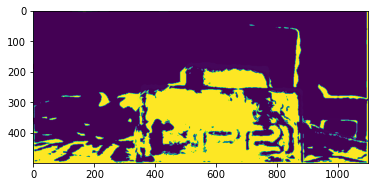

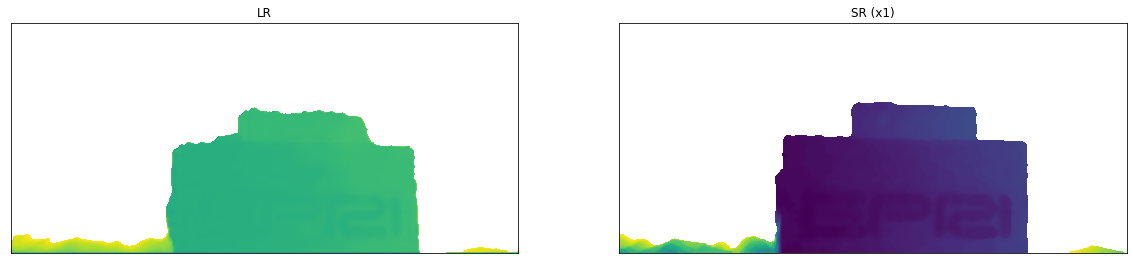

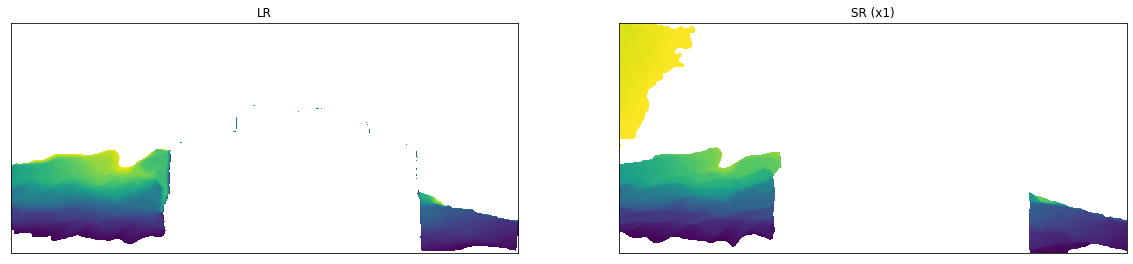

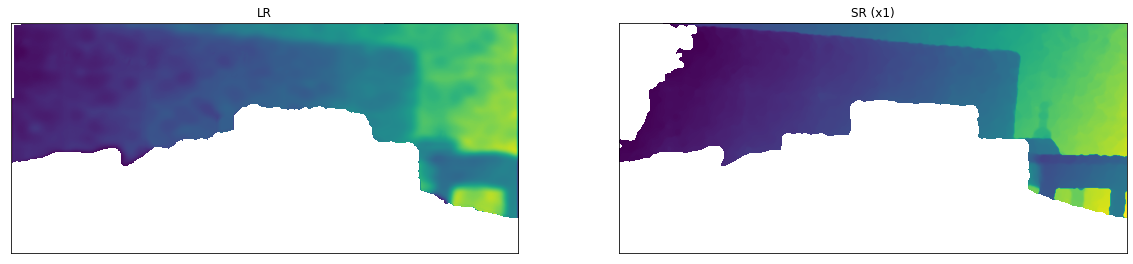

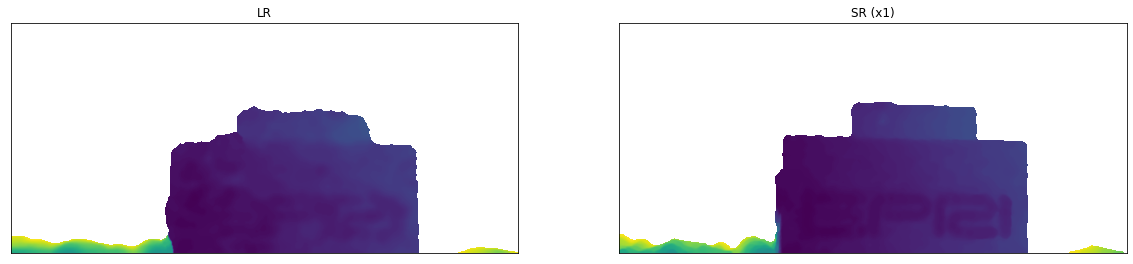

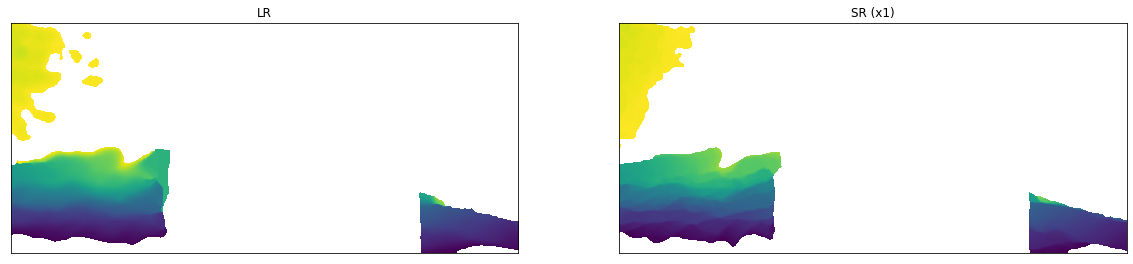

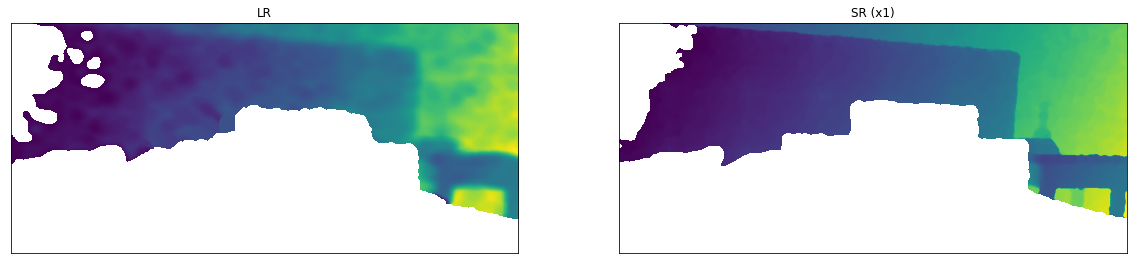

In [17]:
lr = np.array(cv2.imread('demo/lr0.png', cv2.IMREAD_ANYDEPTH))
lr_rgb = np.array(cv2.imread('demo/col_lr.png',cv2.IMREAD_GRAYSCALE))
hr = np.array(cv2.imread('demo/hr0.png', cv2.IMREAD_ANYDEPTH))
hr_rgb = np.array(cv2.imread('demo/col_hr.png',cv2.IMREAD_GRAYSCALE))


(score, diff) = structural_similarity(lr, hr, data_range=2500., full=True)  
print(np.max(diff),np.min(diff))
downsample_rate = 1

#lr = lr[:512, 0::downsample_rate]
#hr = hr[:512, 0::downsample_rate]
#lr_rgb = lr_rgb[:512, 0::downsample_rate]

lr = np.expand_dims(lr,2)  
lr_rgb = np.expand_dims(lr_rgb,2)  

lrmerged = np.concatenate([lr, lr_rgb], 2)    
sr = resolve_single(model, lrmerged)

sr_array = np.array(sr[:,:,0])
depth = sr_array.astype(np.uint16)
print(np.shape(depth),np.shape(hr))
cv2.imwrite('demo/0_res.png',depth)    
        
plt.imshow(depth- hr)
bins = [700,1500]
print("------predicted----------")

print(np.shape(depth),np.shape(hr))
compute_bins(depth, hr, bins)
(score, diff) = structural_similarity(depth, hr, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM predicted whole image: {}".format(round(score, 5)))
print("PNSR predicted whole image: {}".format(round(PSNR(depth, hr), 5)))

print("")
print("------original----------")
lr = lr[:,:,0]
print(np.shape(lr),np.shape(hr))
compute_bins(lr, hr, bins)
(score, diff) = structural_similarity(lr, hr, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM original whole image: {}".format(round(score,5)))
print("PNSR original whole image:  {}".format(round(PSNR(lr, hr),5)))



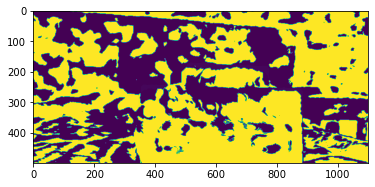

In [18]:
plt.imshow(lr - hr)